# Data preprocessing 

In [1]:
import os
import json
import gzip
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from urllib.request import urlopen
from numpy.linalg import norm
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

# default plot configurations 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

## Start loading data

The data we retrived is consisted with 6 days tweets data which is sampled every 30 minutes each day, from April 28th to May 3rd. Meta here stands for the overview snapshot for our whole data set. 

In [2]:
data = json.load(open('dataset/nft_tweets.json'))
# data

In [3]:
data_overview = pd.json_normalize(data)
data_overview.head()

,data,includes.users,meta.newest_id,meta.oldest_id,meta.result_count,meta.next_token
0,"[{'public_metrics': {'retweet_count': 0, 'repl...","[{'id': '1181641903009341440', 'public_metrics...",1519473920704983042,1519468776202194945,100,b26v89c19zqg8o3fpytot5bz2omnsan5sm6u283nf87zx


### Load author data

The way we arrange our data is: we have the author information for each tweet, which contains the author's id, the time when this tweet is created, the number of total tweets this author has published so far(public_metrics.retweet_count), the number of replies this author has sent so far(public_metrics.reply_count), the number of likes from other users for this tweet(public_metrics.like_count), and also number of quotes for this tweet(public_metrics.like_count). We have author is for each tweet, and its own id is shown as 'id'. Text stands for the content of this tweet. 

In [4]:
author_data = pd.json_normalize(data,record_path = ['data'])
author_data.drop(columns=['geo.place_id','geo.coordinates.type','geo.coordinates.coordinates'],inplace=True)
author_data.head()

,text,created_at,id,author_id,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count
0,Yet not a single app works.\n\nWE NEED BADLY a...,2022-04-28T00:29:47.000Z,1519473920704983042,1181641903009341440,0,2,1,0
1,@binance CYLUM $ project will be one of the mo...,2022-04-28T00:29:21.000Z,1519473810793242626,1441693405583593478,0,0,0,0
2,@SenorAxie @CryptoGeekzNFT @PickwinkangNFT @gu...,2022-04-28T00:29:09.000Z,1519473760273039360,3008000582,0,0,1,0
3,Big yikes if these AI platforms are rememberin...,2022-04-28T00:28:46.000Z,1519473664294535170,1208948613189160961,0,3,5,0
4,Put your NFT's on Public Display..\nAnywhere.....,2022-04-28T00:28:33.000Z,1519473608237662210,2542802983,0,0,1,0


### Follower data

We have also collected detailed data about numebr of fans, number of following counts, number of tweets of each user. There data can be helpful when we analysis the influences of social media has for the NFT market price. 

In [5]:
follower_data_raw = data["includes"]["users"]
# follower_data_raw

This function is used to solve nested sturcture in our dataset. 

In [6]:
def dropnested(alist):
    outputdict = {}
    for dic in alist:
        for key, value in dic.items():
            if isinstance(value, dict):
                for k2, v2, in value.items():
                    outputdict[k2] = outputdict.get(k2, []) + [v2]
            else:
                outputdict[key] = outputdict.get(key, []) + [value]
    return outputdict   

In [7]:
follower_data = pd.DataFrame.from_dict(dropnested(follower_data_raw))
follower_data.head()

,id,followers_count,following_count,tweet_count,listed_count,username,name
0,1181641903009341440,509,512,39015,6,cryptoken_board,cryptoken board ℠
1,1441693405583593478,5,56,414,3,AliGhiasvand77,Anonymous boy
2,3008000582,556,1320,10098,2,Jeruk4444,█║Nash║▌🌟
3,1208948613189160961,477,74,335,3,BeckerrJon,Jonathan Becker | jbecker.eth
4,2542802983,433,3641,6029,11,DaLeewoke,DaLee Woke


### Join two tables together 

Now, we combine these two dataframe together based on tweets' id to have a completed view of the whole dataset. 

In [8]:
follower_data = follower_data.rename({"id": "author_id"}, axis='columns')

In [9]:
follower_data = follower_data.drop_duplicates(subset=['author_id'])
follower_data.shape

(7709, 7)

In [10]:
follower_data.head()

,author_id,followers_count,following_count,tweet_count,listed_count,username,name
0,1181641903009341440,509,512,39015,6,cryptoken_board,cryptoken board ℠
1,1441693405583593478,5,56,414,3,AliGhiasvand77,Anonymous boy
2,3008000582,556,1320,10098,2,Jeruk4444,█║Nash║▌🌟
3,1208948613189160961,477,74,335,3,BeckerrJon,Jonathan Becker | jbecker.eth
4,2542802983,433,3641,6029,11,DaLeewoke,DaLee Woke


In [11]:
author_data = author_data.rename({"id": "tweet_id"}, axis='columns')
author_data.shape

(28733, 8)

In [12]:
author_data.head()

,text,created_at,tweet_id,author_id,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count
0,Yet not a single app works.\n\nWE NEED BADLY a...,2022-04-28T00:29:47.000Z,1519473920704983042,1181641903009341440,0,2,1,0
1,@binance CYLUM $ project will be one of the mo...,2022-04-28T00:29:21.000Z,1519473810793242626,1441693405583593478,0,0,0,0
2,@SenorAxie @CryptoGeekzNFT @PickwinkangNFT @gu...,2022-04-28T00:29:09.000Z,1519473760273039360,3008000582,0,0,1,0
3,Big yikes if these AI platforms are rememberin...,2022-04-28T00:28:46.000Z,1519473664294535170,1208948613189160961,0,3,5,0
4,Put your NFT's on Public Display..\nAnywhere.....,2022-04-28T00:28:33.000Z,1519473608237662210,2542802983,0,0,1,0


In [13]:
complete_data = author_data.merge(follower_data, on='author_id', how='left')
complete_data = complete_data.fillna(0)
complete_data['text'] = complete_data['text'].astype('str')
complete_data

,text,created_at,tweet_id,author_id,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count,followers_count,following_count,tweet_count,listed_count,username,name
0,Yet not a single app works.\n\nWE NEED BADLY a...,2022-04-28T00:29:47.000Z,1519473920704983042,1181641903009341440,0,2,1,0,509,512,39015,6,cryptoken_board,cryptoken board ℠
1,@binance CYLUM $ project will be one of the mo...,2022-04-28T00:29:21.000Z,1519473810793242626,1441693405583593478,0,0,0,0,5,56,414,3,AliGhiasvand77,Anonymous boy
2,@SenorAxie @CryptoGeekzNFT @PickwinkangNFT @gu...,2022-04-28T00:29:09.000Z,1519473760273039360,3008000582,0,0,1,0,556,1320,10098,2,Jeruk4444,█║Nash║▌🌟
3,Big yikes if these AI platforms are rememberin...,2022-04-28T00:28:46.000Z,1519473664294535170,1208948613189160961,0,3,5,0,477,74,335,3,BeckerrJon,Jonathan Becker | jbecker.eth
4,Put your NFT's on Public Display..\nAnywhere.....,2022-04-28T00:28:33.000Z,1519473608237662210,2542802983,0,0,1,0,433,3641,6029,11,DaLeewoke,DaLee Woke
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28728,👉 I just joined the movement! #BlueZilla's mak...,2022-05-03T23:49:34.000Z,1521638124455145472,755561434931572737,0,0,0,1,7,65,43,1,omar_fahimi99,mr zbida
28729,👉 I just joined the movement! #BlueZilla's mak...,2022-05-03T23:49:24.000Z,1521638083749453825,1464617797011623939,0,0,0,0,0,11,1,0,WirghtElizabeth,Wirght Elizabeth
28730,FairLaunch coming soon at Pinksale!\n\nStart: ...,2022-05-03T23:49:13.000Z,1521638038568411137,1519004956136816642,7,6,36,0,1620,8,12,0,MoveningE,Movening Official
28731,The only NFT collection that gives you access ...,2022-05-03T23:49:06.000Z,1521638009032093696,1517595559011528705,0,0,0,0,6461,2,27,0,tradebots_sol,Trade Bots


### Process twitter text 

The tweets data we directly fetch from social media may contain invalid format for our sentiment analysis model. Therefore, we should do some preprocessing on tweets' contents. 

In [14]:
import re # regular expressions
from tqdm import tnrange, tqdm_notebook, tqdm

for i,s in enumerate(tqdm(complete_data['text'])):
    text = complete_data.loc[i, 'text']
    text = text.replace("#", "")
    text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text, flags=re.MULTILINE)
    text = re.sub('@\\w+ *', '', text, flags=re.MULTILINE)
    complete_data.loc[i, 'text'] = text

complete_data.head()


100%|████████████████████████████████████| 28733/28733 [00:32<00:00, 897.34it/s]


,text,created_at,tweet_id,author_id,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count,followers_count,following_count,tweet_count,listed_count,username,name
0,Yet not a single app works.\n\nWE NEED BADLY a...,2022-04-28T00:29:47.000Z,1519473920704983042,1181641903009341440,0,2,1,0,509,512,39015,6,cryptoken_board,cryptoken board ℠
1,CYLUM $ project will be one of the most powerf...,2022-04-28T00:29:21.000Z,1519473810793242626,1441693405583593478,0,0,0,0,5,56,414,3,AliGhiasvand77,Anonymous boy
2,\n\nElom musk Buy twitter its signal if Crypto...,2022-04-28T00:29:09.000Z,1519473760273039360,3008000582,0,0,1,0,556,1320,10098,2,Jeruk4444,█║Nash║▌🌟
3,Big yikes if these AI platforms are rememberin...,2022-04-28T00:28:46.000Z,1519473664294535170,1208948613189160961,0,3,5,0,477,74,335,3,BeckerrJon,Jonathan Becker | jbecker.eth
4,Put your NFT's on Public Display..\nAnywhere.....,2022-04-28T00:28:33.000Z,1519473608237662210,2542802983,0,0,1,0,433,3641,6029,11,DaLeewoke,DaLee Woke


### Reformat created date data

We also collect NFT market price data from https://www.binance.com/en/price/nft, however, the timestamp from this website has a different format from the created date data in our twitter dataset. To be more detailed, it doesn't  accurate to the second. Therefore, we will reformat out create date here to prepare for our correlation analysis procedure.  

### Sentiment analysis with Vader

In [70]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm

In [71]:
analyzer = SentimentIntensityAnalyzer()
compound = []
for i,s in enumerate(tqdm(complete_data['text'])):
    vs = analyzer.polarity_scores(s)
    compound.append(vs["compound"])
complete_data["compound"] = compound
complete_data.head(5)

100%|███████████████████████████████████| 28733/28733 [00:04<00:00, 6161.89it/s]


,text,created_at,tweet_id,author_id,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count,followers_count,following_count,...,compound,log_followers_count,log_like_count,log_retweet_count,like_score,follower_score,retweet_score,overall_score,reformat_time,time_cat
0,Yet not a single app works.\n\nWE NEED BADLY a...,2022-04-28T00:29:47.000Z,1519473920704983042,1181641903009341440,0,2,1,0,509,512,...,-0.2342,6.234411,0.693147,0.0,-1.074665,-4.591783,-0.634714,-7.774565,2022-04-28 00:00,0
1,CYLUM $ project will be one of the most powerf...,2022-04-28T00:29:21.000Z,1519473810793242626,1441693405583593478,0,0,0,0,5,56,...,0.9339,1.791759,0.000000,0.0,0.533386,1.489085,0.533386,1.489085,2022-04-28 00:00,0
2,\n\nElom musk Buy twitter its signal if Crypto...,2022-04-28T00:29:09.000Z,1519473760273039360,3008000582,0,0,1,0,556,1320,...,0.7003,6.322565,0.693147,0.0,0.507581,2.195201,0.299786,3.716798,2022-04-28 00:00,0
3,Big yikes if these AI platforms are rememberin...,2022-04-28T00:28:46.000Z,1519473664294535170,1208948613189160961,0,3,5,0,477,74,...,0.0000,6.169611,1.791759,0.0,-1.118139,-2.871531,-0.400514,-8.016624,2022-04-28 00:00,0
4,Put your NFT's on Public Display..\nAnywhere.....,2022-04-28T00:28:33.000Z,1519473608237662210,2542802983,0,0,1,0,433,3641,...,0.0000,6.073045,0.693147,0.0,-0.678130,-2.832855,-0.400514,-4.796440,2022-04-28 00:00,0


In [72]:
# center the data(to take the overall sentiment on twitter into account)
complete_data['compound'] -= complete_data['compound'].mean()

### Calculate a score for each tweet

The compound score for each tweet can only shows the result of sentiment analysis. However, we are talking about the influence from social media on NFT market price, which means that different user may have different influences. We should also consider number of followrs of a author, number of likes received for each tweet, as well as number of retweets. We also would like to know the differences between these parameters, and the total influences they made together. In this part, we computing different scores based on several parameters.

In [73]:
# apply log transform
complete_data['log_followers_count'] = np.log(complete_data['followers_count']+1)
complete_data['log_like_count'] = np.log(complete_data['public_metrics.like_count']+1)
complete_data['log_retweet_count'] = np.log(complete_data['public_metrics.retweet_count']+1)

In [74]:
# score1,score2,score3, score4 = [],[],[],[]
# for i, s in tqdm(complete_data.iterrows(), total=complete_data.shape[0]):
#     score1.append(s["compound"] * (s["followers_count"]+1)) # consider number of likes
#     score2.append(s["compound"] * (s["public_metrics.like_count"]+1)) # consider number of followers
#     score3.append(s["compound"] * (s["public_metrics.retweet_count"]+1)) # consider number of retweets 
#     score4.append(s["compound"] * (s["followers_count"]+1) * (s["public_metrics.like_count"]+1) * (s["public_metrics.retweet_count"]+1)) # consider all of these 
    
# complete_data["like_score"] = score1
# complete_data["follower_score"] = score2 
# complete_data["retweet_score"] = score3
# complete_data["overall_score"] = score4
# complete_data.head()

In [75]:
score1,score2,score3, score4 = [],[],[],[]
for i, s in tqdm(complete_data.iterrows(), total=complete_data.shape[0]):
    score1.append(s["compound"] * (s["log_like_count"]+1)) # consider number of likes
    score2.append(s["compound"] * (s["log_followers_count"]+1)) # consider number of followers
    score3.append(s["compound"] * (s["log_retweet_count"]+1)) # consider number of retweets 
    score4.append(s["compound"] * (s["log_followers_count"]+1) * (s["log_like_count"]+1) * (s["log_retweet_count"]+1)) # consider all of these 
    
complete_data["like_score"] = score1
complete_data["follower_score"] = score2 
complete_data["retweet_score"] = score3
complete_data["overall_score"] = score4
complete_data.head()

100%|██████████████████████████████████| 28733/28733 [00:02<00:00, 10352.13it/s]


,text,created_at,tweet_id,author_id,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count,followers_count,following_count,...,compound,log_followers_count,log_like_count,log_retweet_count,like_score,follower_score,retweet_score,overall_score,reformat_time,time_cat
0,Yet not a single app works.\n\nWE NEED BADLY a...,2022-04-28T00:29:47.000Z,1519473920704983042,1181641903009341440,0,2,1,0,509,512,...,-0.634714,6.234411,0.693147,0.0,-1.074665,-4.591783,-0.634714,-7.774565,2022-04-28 00:00,0
1,CYLUM $ project will be one of the most powerf...,2022-04-28T00:29:21.000Z,1519473810793242626,1441693405583593478,0,0,0,0,5,56,...,0.533386,1.791759,0.000000,0.0,0.533386,1.489085,0.533386,1.489085,2022-04-28 00:00,0
2,\n\nElom musk Buy twitter its signal if Crypto...,2022-04-28T00:29:09.000Z,1519473760273039360,3008000582,0,0,1,0,556,1320,...,0.299786,6.322565,0.693147,0.0,0.507581,2.195201,0.299786,3.716798,2022-04-28 00:00,0
3,Big yikes if these AI platforms are rememberin...,2022-04-28T00:28:46.000Z,1519473664294535170,1208948613189160961,0,3,5,0,477,74,...,-0.400514,6.169611,1.791759,0.0,-1.118139,-2.871531,-0.400514,-8.016624,2022-04-28 00:00,0
4,Put your NFT's on Public Display..\nAnywhere.....,2022-04-28T00:28:33.000Z,1519473608237662210,2542802983,0,0,1,0,433,3641,...,-0.400514,6.073045,0.693147,0.0,-0.678130,-2.832855,-0.400514,-4.796440,2022-04-28 00:00,0


### Crypto currency data preprocessing 

In [76]:
def reformat(time):
#     return re.findall('(.*)', time)
    year, date = re.findall('(\d+-\d+-\d+)T(\d+:\d+).*', time)[0]
#     print(year, data)
    hour, minute = date.split(":")
    if int(minute) <= 29:
        minute = "00"
    else:
        minute = "30"
        
    return "{} {}:{}".format(year, hour, minute)
reformat(complete_data.loc[0, 'created_at'])

'2022-04-28 00:00'

In [77]:
# def categorize(time):
#     year, date = re.findall('(\d+-\d+-\d+)T(\d+:\d+).*', time)[0]
#     hour, minute = date.split(":")
#     if int(minute) <= 29:
#         offset = 0
#     else:
#         offset = 1
        
#     return int(hour)*2+int(offset)
# categorize(complete_data.loc[0, 'created_at'])

In [78]:
complete_data['reformat_time'] = complete_data['created_at'].apply(reformat)
# complete_data['time_cat'] = complete_data['created_at'].apply(categorize)

complete_data

,text,created_at,tweet_id,author_id,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count,followers_count,following_count,...,compound,log_followers_count,log_like_count,log_retweet_count,like_score,follower_score,retweet_score,overall_score,reformat_time,time_cat
0,Yet not a single app works.\n\nWE NEED BADLY a...,2022-04-28T00:29:47.000Z,1519473920704983042,1181641903009341440,0,2,1,0,509,512,...,-0.634714,6.234411,0.693147,0.000000,-1.074665,-4.591783,-0.634714,-7.774565,2022-04-28 00:00,0
1,CYLUM $ project will be one of the most powerf...,2022-04-28T00:29:21.000Z,1519473810793242626,1441693405583593478,0,0,0,0,5,56,...,0.533386,1.791759,0.000000,0.000000,0.533386,1.489085,0.533386,1.489085,2022-04-28 00:00,0
2,\n\nElom musk Buy twitter its signal if Crypto...,2022-04-28T00:29:09.000Z,1519473760273039360,3008000582,0,0,1,0,556,1320,...,0.299786,6.322565,0.693147,0.000000,0.507581,2.195201,0.299786,3.716798,2022-04-28 00:00,0
3,Big yikes if these AI platforms are rememberin...,2022-04-28T00:28:46.000Z,1519473664294535170,1208948613189160961,0,3,5,0,477,74,...,-0.400514,6.169611,1.791759,0.000000,-1.118139,-2.871531,-0.400514,-8.016624,2022-04-28 00:00,0
4,Put your NFT's on Public Display..\nAnywhere.....,2022-04-28T00:28:33.000Z,1519473608237662210,2542802983,0,0,1,0,433,3641,...,-0.400514,6.073045,0.693147,0.000000,-0.678130,-2.832855,-0.400514,-4.796440,2022-04-28 00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28728,👉 I just joined the movement! BlueZilla's maki...,2022-05-03T23:49:34.000Z,1521638124455145472,755561434931572737,0,0,0,1,7,65,...,0.017886,2.079442,0.000000,0.000000,0.017886,0.055078,0.017886,0.055078,2022-05-03 23:30,47
28729,👉 I just joined the movement! BlueZilla's maki...,2022-05-03T23:49:24.000Z,1521638083749453825,1464617797011623939,0,0,0,0,0,11,...,0.017886,0.000000,0.000000,0.000000,0.017886,0.017886,0.017886,0.017886,2022-05-03 23:30,47
28730,FairLaunch coming soon at Pinksale!\n\nStart: ...,2022-05-03T23:49:13.000Z,1521638038568411137,1519004956136816642,7,6,36,0,1620,8,...,-0.400514,7.390799,3.610918,2.079442,-1.846738,-3.360634,-1.233360,-47.717819,2022-05-03 23:30,47
28731,The only NFT collection that gives you access ...,2022-05-03T23:49:06.000Z,1521638009032093696,1517595559011528705,0,0,0,0,6461,2,...,0.185386,8.773694,0.000000,0.000000,0.185386,1.811904,0.185386,1.811904,2022-05-03 23:30,47


In [79]:
average_score = complete_data.groupby("reformat_time").median()
selected_features = average_score.loc[:, ["like_score", "follower_score", "retweet_score", "overall_score"]]
scores = selected_features.to_numpy()
scores.shape

(288, 4)

In [80]:
prices = pd.read_csv('dataset/nft_price.csv')['price'].to_numpy()
prices.shape

(288,)

In [81]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor

In [82]:
scores.shape, prices.shape

((288, 4), (288,))

In [83]:
# predict price using linear reg
X_selected = scores[:-1,:]
y = prices[1:]

reg1 = LinearRegression()
reg1.fit(X_selected, y)
y_pred = reg1.predict(X_selected)
((y_pred-y)**2).mean()

0.0008801661638721854

In [84]:
# predict price diff using linear reg
X_selected = scores[:-1, :]
y = prices[1:] - prices[:-1]

reg1 = LinearRegression()
reg1.fit(X_selected, y)
y_pred = reg1.predict(X_selected)
((y_pred-y)**2).mean()

2.802988920706049e-05

In [85]:
# !pip uninstall xgboost
# !pip install xgboost==0.80

In [86]:
# predict actual price using xgboost
X_selected = scores[:-1, :]
y = prices[1:]

reg2 = XGBRegressor()
reg2.fit(X_selected, y)
y_pred = reg2.predict(X_selected)
((y_pred-y)**2).mean()

0.0002755830238418735

In [87]:
# predict price diff using xgboost
X_selected = scores[:-1, :]
y = prices[1:] - prices[:-1]

reg2 = XGBRegressor()
reg2.fit(X_selected, y)
y_pred = reg2.predict(X_selected)
((y_pred-y)**2).mean()

2.3130355936709005e-06

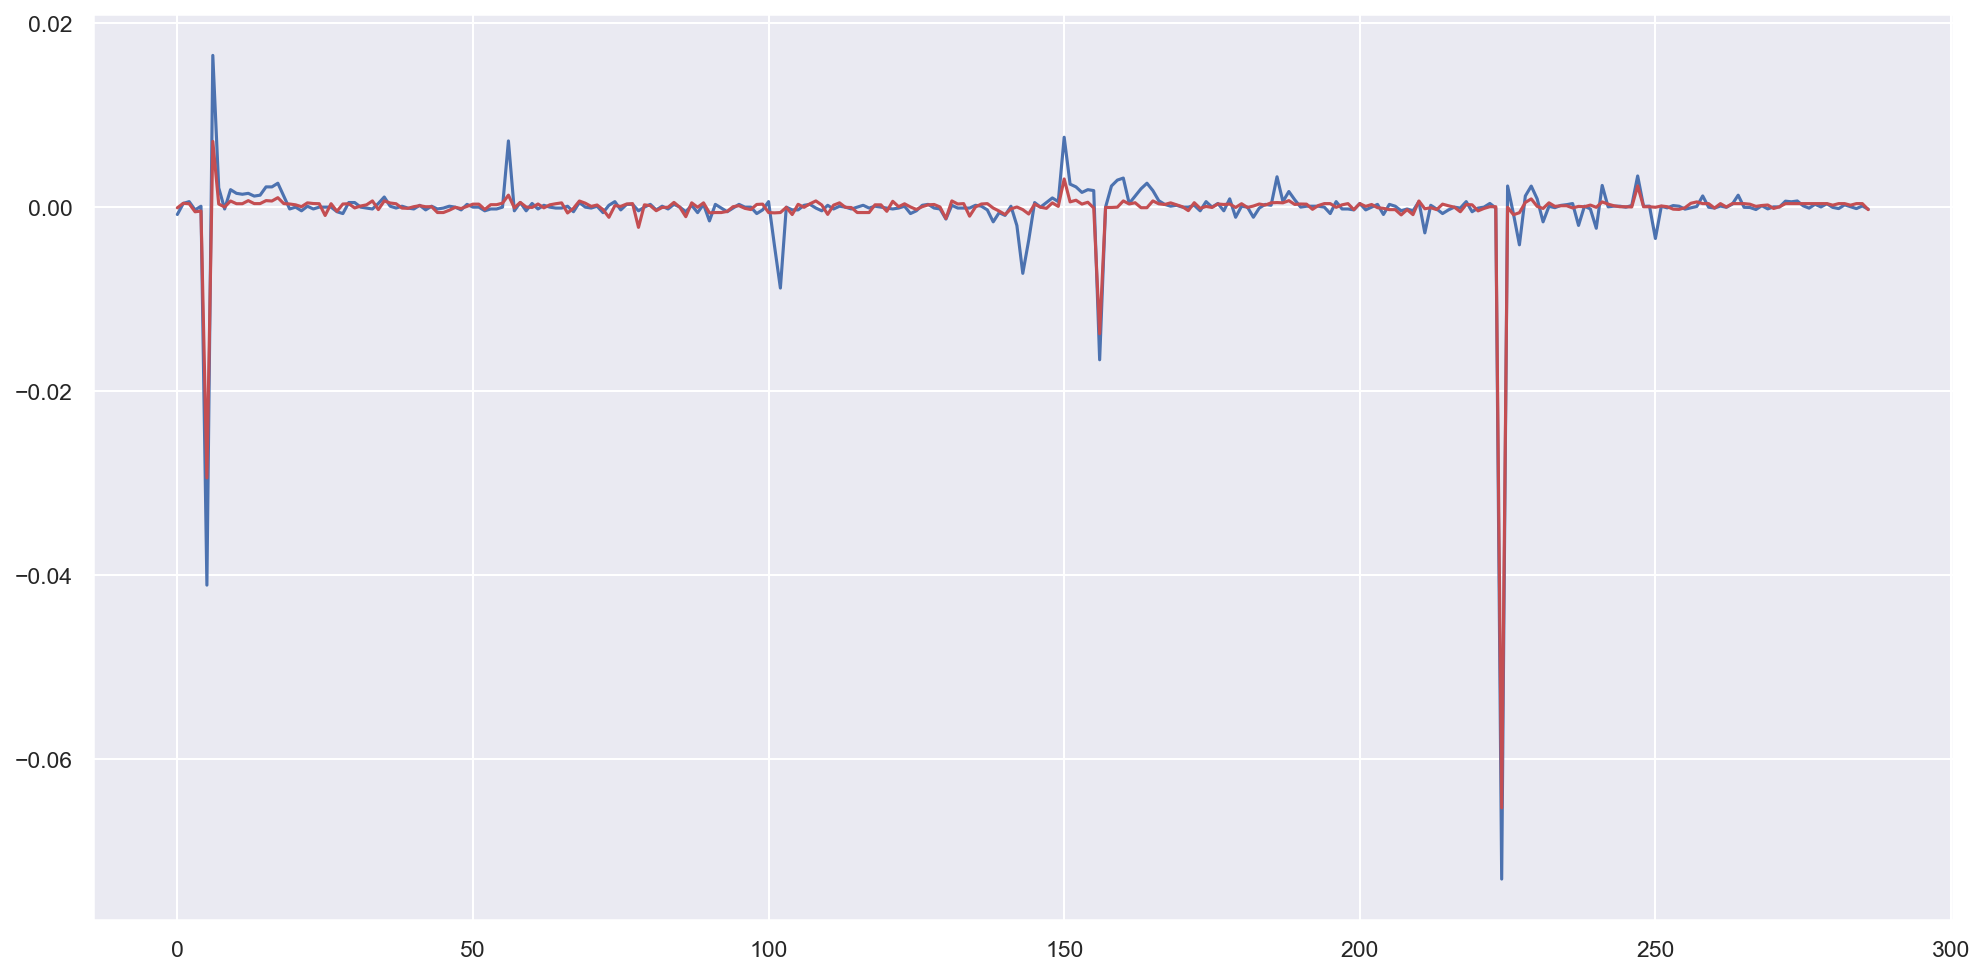

In [67]:
plt.plot(y, color="b")
plt.plot(y_pred, color="r")

### Correlation analysis between the NFT market price and Twitter

### Prediction model 